# TMRCA and relative TMRCA_half statistics from ARGweaver

We use the ARGweaver samples using the entire data set but use stats calculated by using trees pruned to only retain the individuals that are included in the analysis. This pruning is done in the GWF workflow. The statistics based on pruned trees have a `pruned_` suffix.

In [1]:
import re, os, sys, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame

Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Silence deprecation warnings (lots from seaborn)

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code:

In [6]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Compile data frame with ARGweaver TMRCA stats

Read in all the HDF files generated by the GWF workflow and compute relative TMRA half:

In [7]:

tmrca_dir = steps_dir / 'argweaver/tmrca_extra/World'
raw_stats = (pandas.concat(pandas.read_hdf(p) for p in sorted(tmrca_dir.iterdir()))
                   .assign(rel_tmrca_half=lambda df: df.tmrca_half / df.tmrca,
                           pruned_rel_tmrca_half=lambda df: df.pruned_tmrca_half / df.pruned_tmrca)
            )

In [8]:
raw_stats.head(3)

,chain,MCMC_sample,end,pruned_coal_half,pruned_tmrca,pruned_tmrca_half,start,tmrca,tmrca_half,rel_tmrca_half,pruned_rel_tmrca_half
0,1,0,100000,232.1,43080.629023,10684.485731,0,43080.609872,10647.559146,0.247154,0.248011
0,1,10,100000,232.1,42023.594705,11133.887163,0,42023.577946,10904.840513,0.259493,0.264944
0,1,20,100000,232.1,42865.001104,10868.492820,0,42864.980292,10684.614736,0.249262,0.253552


## Analyze convergence of mean statistics from samples in the two chains

The ARGweaver data is from two chains with diffrent seed. They should produce similar results if the MCMC converges and mixes well. 

Plot the `tmrca` and `tmrca_half` for each chain:

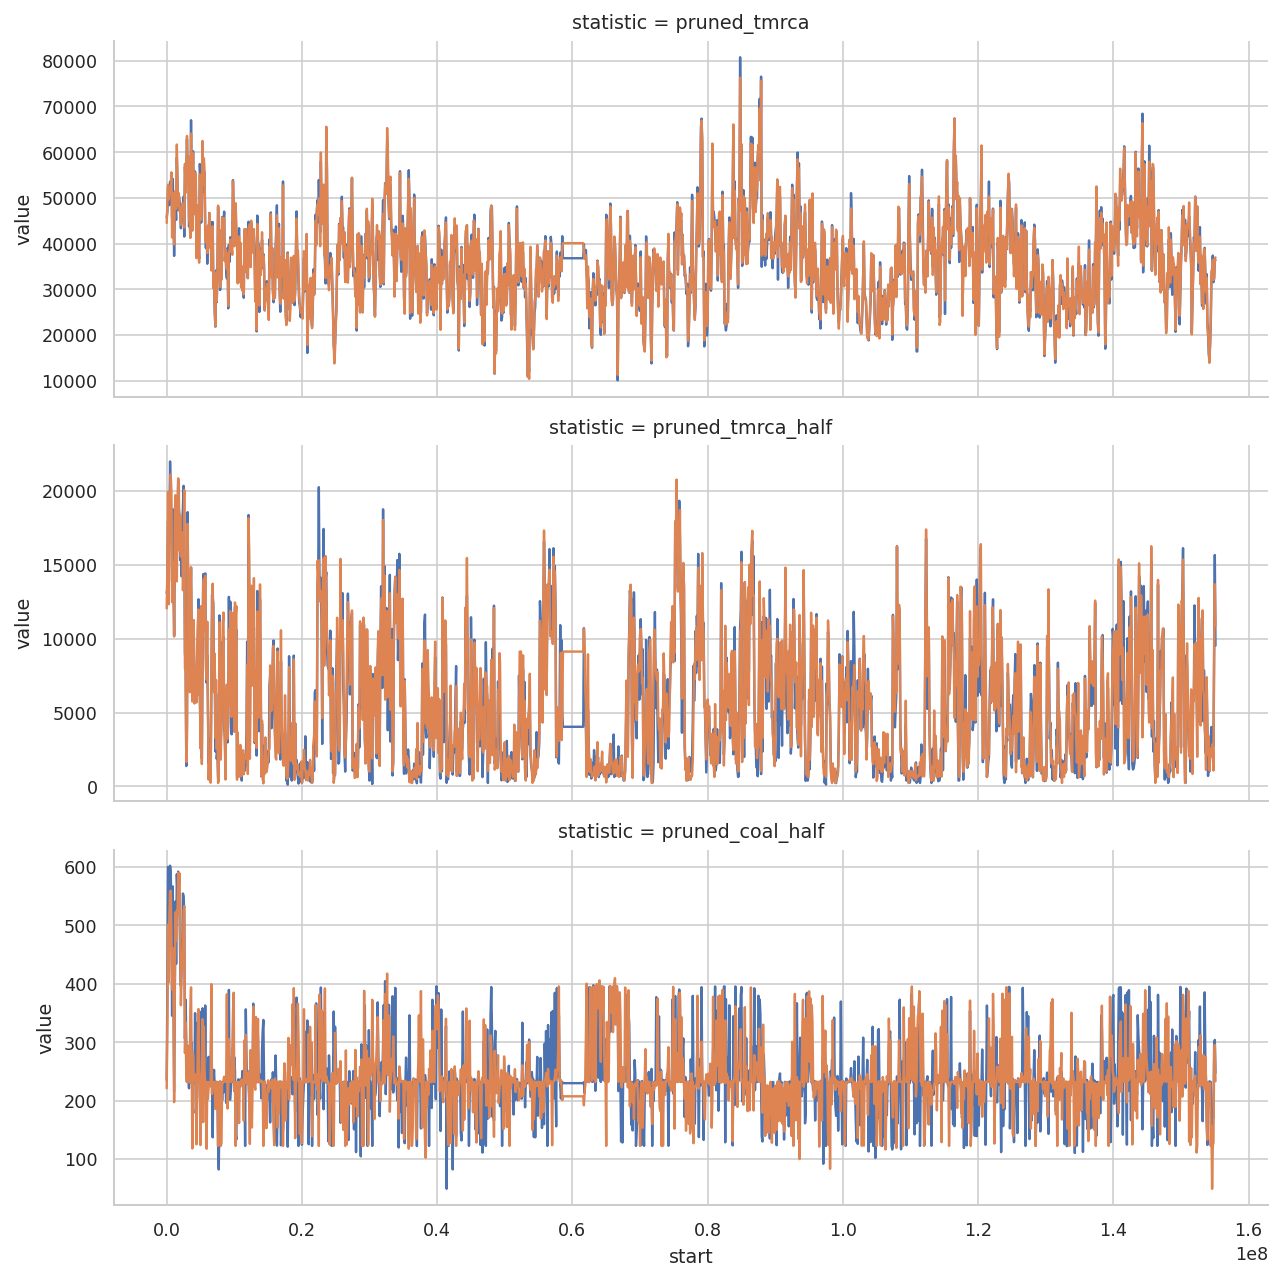

In [9]:
df = (raw_stats
      .groupby(['start', 'end', 'chain'])
      .mean()
      .reset_index()      
     )
plot_df = pandas.melt(df, 
                  id_vars=['start', 'chain'], 
                  value_vars=['pruned_tmrca', 'pruned_tmrca_half', 'pruned_coal_half'], 
                  var_name='statistic', value_name='value')

g = sns.FacetGrid(plot_df, row='statistic', hue='chain', height=3, aspect=3, sharey=False)

fig = g.map(plt.plot, 'start', "value")

# fig = g.map(plt.plot, 'start', "value").fig
# mpld3.display(fig)

See if the correlation between arg stats in the two chains improve the longer they have run:

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


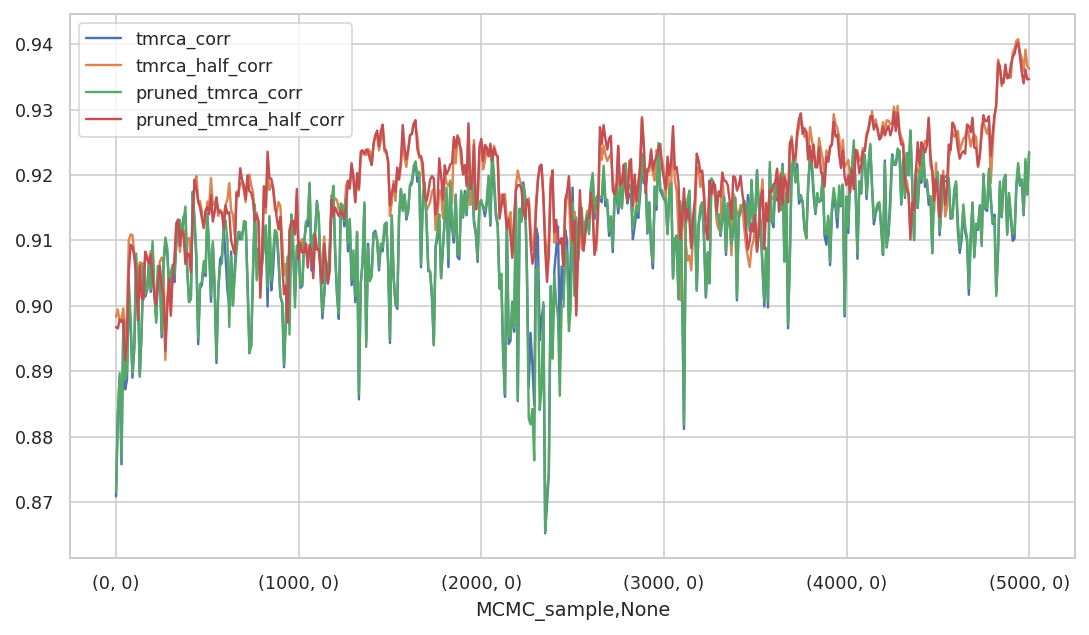

In [10]:
stats_list = ['tmrca', 'tmrca_half', 'pruned_tmrca', 'pruned_tmrca_half']

def cross_chain_corr(df):
    result_df = DataFrame()
    for stat in stats_list:
        chain0 = df.loc[df.chain == 1, ['start', stat]]
        chain1 = df.loc[df.chain == 2, ['start', stat]]
        both = pandas.merge(chain0, chain1, on='start', how='inner', 
                            suffixes=['_chain0', '_chain1'])
        result_df[stat + '_corr'] = [both[stat + '_chain0'].corr(both[stat + '_chain1'])]
    return result_df
        
g = (raw_stats#stats_by_sample_df
     .reset_index()
     .groupby('MCMC_sample')
     .apply(cross_chain_corr)
     .plot(figsize=(9, 5))
    )


## Merge data from the two chains and compute mean stats

We discard the first 500 samples as burnin:

In [11]:
pruned_tmrca_stats = (raw_stats
                      .loc[lambda df: df.MCMC_sample >= 500]
                      .groupby(['start', 'end'])
                      .mean()
                      .reset_index()
                     )

Note that we delete the unpruned stats and remove the `pruned_` prefix on the pruned column names:

In [12]:
del pruned_tmrca_stats['tmrca']
del pruned_tmrca_stats['tmrca_half']
del pruned_tmrca_stats['rel_tmrca_half']

pruned_tmrca_stats.rename(columns={'pruned_tmrca': 'tmrca', 
                                   'pruned_tmrca_half': 'tmrca_half', 
                                   'pruned_rel_tmrca_half': 'rel_tmrca_half', 
                                   'pruned_coal_half': 'coal_half'},
                         inplace=True)

## Write mean stats for merged chains to hdf

Note that we skip the `pruned_` prefix on the column names in the file written to disk:

In [13]:
pruned_tmrca_stats.to_hdf(str(results_dir / 'pruned_tmrca_stats.hdf'), 'df', format='table', mode='w')

## TMRCA and TMRCA_half across chrX

Plot the stats for both chains pooled:

No handles with labels found to put in legend.


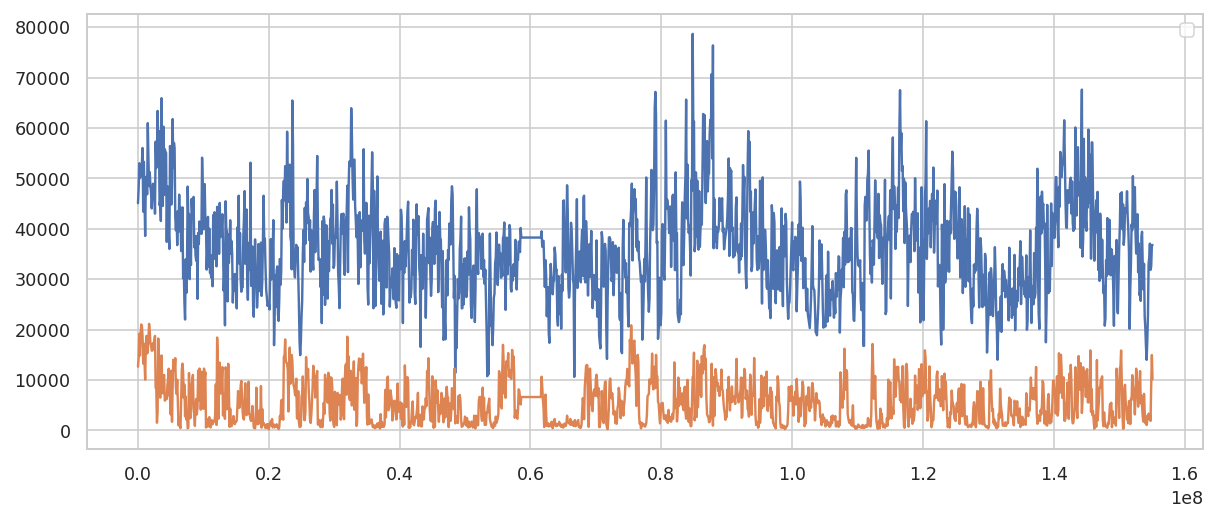

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(pruned_tmrca_stats.start, pruned_tmrca_stats.tmrca)
ax.plot(pruned_tmrca_stats.start, pruned_tmrca_stats.tmrca_half)
ax.legend(loc='upper right')
plt.show()

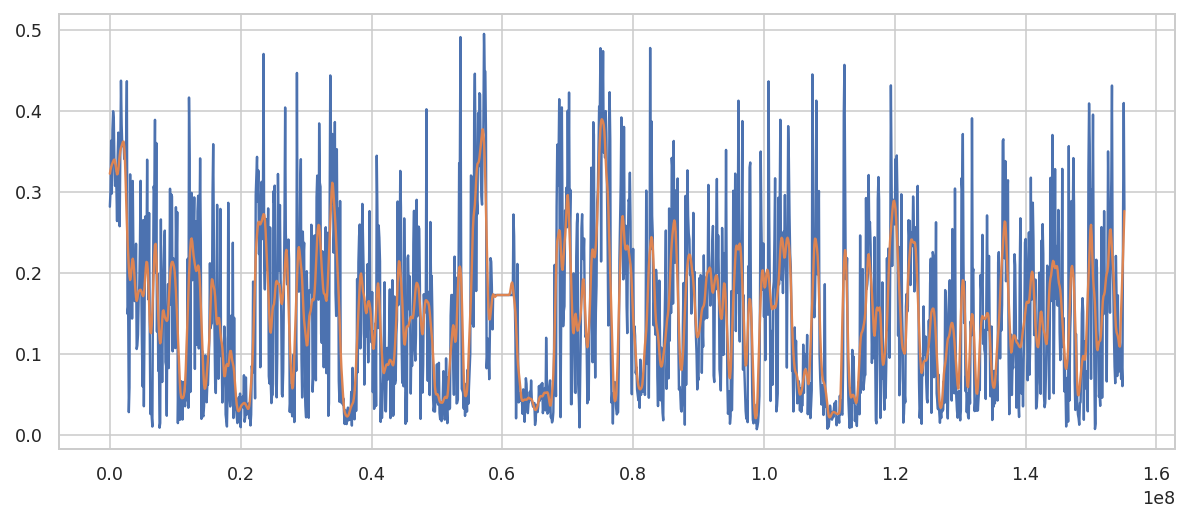

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ratio = pruned_tmrca_stats.rel_tmrca_half
ax.plot(pruned_tmrca_stats.start, ratio)

filtered = lowess(ratio, pruned_tmrca_stats.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

Plot the $-\log\Big[\frac{TMRCA_{half}}{TMRCA}\Big]$

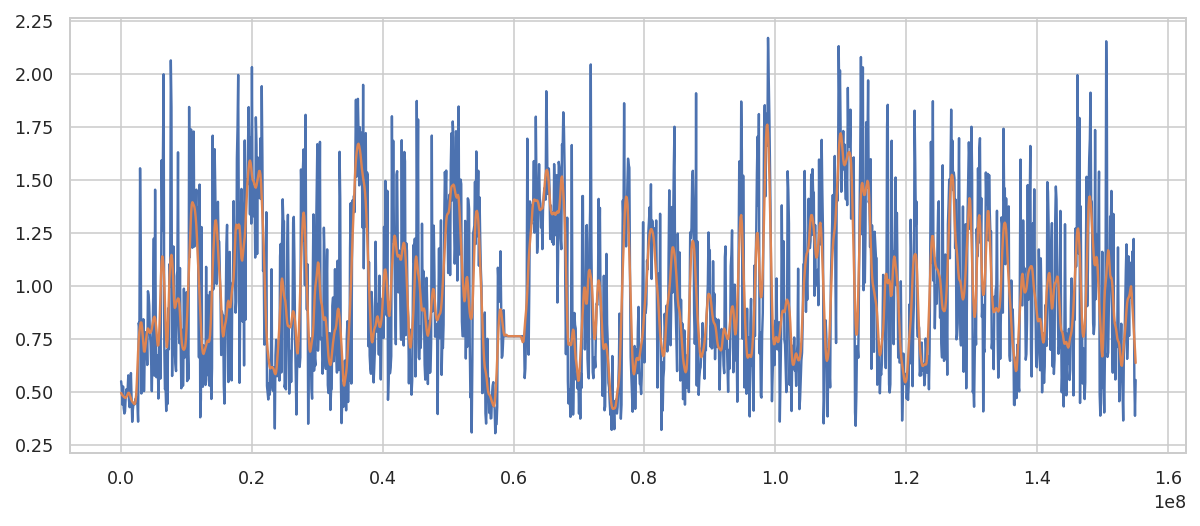

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(pruned_tmrca_stats.rel_tmrca_half)
ax.plot(pruned_tmrca_stats.start, log_ratio)

filtered = lowess(log_ratio, pruned_tmrca_stats.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

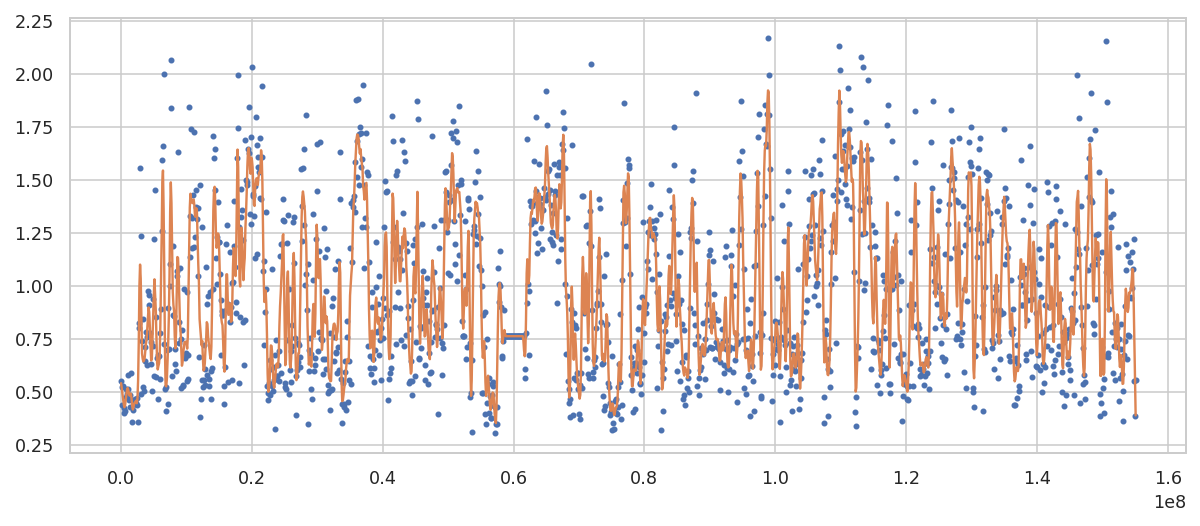

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(pruned_tmrca_stats.rel_tmrca_half)
ax.plot(pruned_tmrca_stats.start, log_ratio, 'o', ms=2)

filtered = lowess(log_ratio, pruned_tmrca_stats.start, is_sorted=True, frac=0.005, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()